In [1]:
import os
import time
from datetime import datetime
import numpy as np
#import matplotlib.pyplot as plt
from collections import deque
import gym
import pandas as pd
from pathlib import Path
import sys
import random
import tensorflow as tf
from sqlalchemy import create_engine

from environments import PortfolioEnvironment, PortfolioEnvironmentTargetReward
from utils import ReplayBufferMultiObs
from policies import TD3, MarkowitzAgent

In [2]:
def reshape_dict_state(state):
    obs = {}
    for key,value in state.items():
        obs[key] = np.array([value])
    return obs

In [3]:
engine = create_engine(f'mysql+pymysql://{os.environ["MYSQL_USER"]}:{os.environ["MYSQL_PASSWORD"]}@{os.environ["MYSQL_SERVER"]}:{os.environ["MYSQL_PORT"]}/tfm')

In [4]:
seed = 0
load_model = False
start_timesteps = 3e4 if not load_model else 1e3 # Number of timesteps in which the model choose a random action, after that number starts using the policy
save_freq = 5e3
max_timesteps = 3e6 
expl_noise = 0.3 # Exploration noise 
batch_size = 100 
discount = 0.97 # reward Discount factor gamma 
tau = 0.005 # target weights update ratio
policy_noise = 0.1 # std deviation of gaussian noise to be added to the action, for exploration purposes
noise_clip = 0.9 # max value of gaussian noise added to action
policy_freq = 2 # actor model weights update frecuency


In [5]:
model_path = './models/26_05_2022_14_12_57' 
max_steps = 200
fee = 0.25/100
window = 50

In [6]:
tickers = "('AAPL','AMZN','BA','COIN','FB','GM','GOLD','GOOG','JNJ','JPM','KO','MSFT','NKE','NVDA','PFE','SPY','SQ','TSLA','V','WMT','XOM')"

In [7]:
#tickers = ['AAPL','AMZN','GM','GOLD','JPM','MSFT','NVDA','KO','TSLA','V','XOM','WMT']
assets_data_list = []
assets_data_list_test = []
tickers = {v: k for k, v in engine.execute(f"SELECT id,ticker FROM tickers where ticker in {tickers} order by id asc").fetchall()}
for t in tickers.keys():
    #assets_data_list.append(pd.read_csv(f'./data/{t}.csv'))
    assets_data_list.append(pd.read_sql(f"SELECT close,high,low from historical_hour inner join tickers on ticker_id = tickers.id where ticker = '{t}' order by time asc",engine))
    assets_data_list_test.append(assets_data_list[-1].tail(max_steps+window))
    assets_data_list[-1] = assets_data_list[-1].iloc[:assets_data_list[-1].shape[0]-max_steps,]

target = pd.read_sql("select close from historical_hour inner join tickers on ticker_id = tickers.id where ticker = 'SPY' order by time asc",engine)

In [8]:
env = PortfolioEnvironment(tickers.keys(),assets_data_list,fee=fee,look_back_window=window,max_steps=max_steps)
#env = PortfolioEnvironmentTargetReward(tickers.keys(),assets_data_list,target.to_numpy().reshape(1,-1)[0],fee=fee,look_back_window=window,max_steps=max_steps)


In [9]:
state_dim = env.observation_space["data"].shape
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

In [10]:
policy = TD3(state_dim,action_dim,max_action)

replay_buffer = ReplayBufferMultiObs()

In [11]:
if load_model:
    policy.load(model_path)

In [12]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
saved_models_path = f'./models/{datetime.now().strftime("%d_%m_%Y_%H_%M_%S")}'

In [13]:
start_time=time.time()
info_list = []
while total_timesteps < max_timesteps:
    if done:
        if total_timesteps != 0:
            #print(f'Total timesteps: {total_timesteps} Episode Num: {episode_num} Reward: {episode_reward} Portfolio Value:{env.portfolio_value_units}')
            policy.train(replay_buffer,episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)
        
        if timesteps_since_eval >= save_freq:
            timesteps_since_eval %= save_freq
            policy.save(saved_models_path)
            print(f'Total timesteps: {total_timesteps} Episode Num: {episode_num} Reward: {episode_reward} Portfolio Value:{env.portfolio_value_units}')

        
        obs = env.reset()
        done = False
        
        episode_reward = 0
        episode_timesteps = 0
        episode_num +=1
        
    if total_timesteps < start_timesteps:
        action = tf.nn.softmax(env.action_space.sample()+ np.random.normal(0,1,size=env.action_space.shape[0])).numpy()
        #action = np.clip(np.random.normal(2,3,size=env.action_space.shape[0]),0,None)
        #action = action/action.sum()
    else:
        action = policy.select_action(reshape_dict_state(obs))
        #print(action)
        if expl_noise != 0: 
            #action = np.clip(action + np.random.normal(0,expl_noise,size=env.action_space.shape[0]),0,None)
            #action = action/action.sum()
            action = tf.nn.softmax((action + np.random.normal(0,expl_noise,size=env.action_space.shape[0]))).numpy()
    
    
    next_obs,reward,done, info = env.step(action)
    info_list.append(info)
    done_bool = 0 if episode_timesteps +1 == env.max_steps else float(done)
    
    
    episode_reward += reward
    replay_buffer.add((obs,next_obs,action,reward,done_bool))
    
    obs = next_obs
    episode_timesteps +=1
    total_timesteps +=1
    timesteps_since_eval +=1


policy.save(saved_models_path)
print(f'Tiempo de entrenamiento: {time.time()-start_time} segundos')

Total timesteps: 5076 Episode Num: 27 Reward: -42203.37151159556 Portfolio Value:57796.62848840444
Total timesteps: 10119 Episode Num: 54 Reward: -39237.94236896201 Portfolio Value:60762.05763103799
Total timesteps: 15187 Episode Num: 81 Reward: -31377.56313799786 Portfolio Value:68622.43686200214
Total timesteps: 20134 Episode Num: 106 Reward: -40656.00378940931 Portfolio Value:59343.99621059069
Total timesteps: 25149 Episode Num: 133 Reward: -35753.88952595833 Portfolio Value:64246.11047404167
Total timesteps: 30111 Episode Num: 158 Reward: -31266.27083777827 Portfolio Value:68733.72916222173
Total timesteps: 35184 Episode Num: 184 Reward: -20989.197620893727 Portfolio Value:79010.80237910627
Total timesteps: 40065 Episode Num: 210 Reward: -4306.048519310119 Portfolio Value:95693.95148068988
Total timesteps: 45135 Episode Num: 236 Reward: -20851.9445814302 Portfolio Value:79148.0554185698
Total timesteps: 50023 Episode Num: 261 Reward: -7855.88325588718 Portfolio Value:92144.11674411

In [15]:
import matplotlib.pyplot as plt
from environments import PortfolioEnvironmentTest,PortfolioEnvironmentTargetRewardTest

In [16]:
env2 = PortfolioEnvironmentTest(tickers.keys(),assets_data_list_test,fee=fee,look_back_window=window)

#for m in os.listdir('./models'):
#policy.load(f'./models/26_05_2022_14_12_57')
#este es el que esta actualmente en el trabajo28_08_2022_10_28_25
policy.load(f'./models/31_08_2022_18_52_47')
state = env2.reset()
done = False
total_reward = 0
infos = []

while not done:
    action = policy.select_action(reshape_dict_state(state))
    state, reward, done, info = env2.step(action)
    #print(reward)
    total_reward += reward
    infos.append(info)
    #print(action)

print(total_reward)

-9264.605044360404


In [14]:
saved_models_path

'./models/31_08_2022_18_52_47'

In [21]:
print(infos[-2])

{'weights': array([0.05806772, 0.04489774, 0.04413041, 0.04436056, 0.04555424,
       0.04486607, 0.04513602, 0.04474359, 0.04491052, 0.04441035,
       0.04507881, 0.04505769, 0.04418441, 0.04480712, 0.04476743,
       0.0452353 , 0.04478065, 0.04515193, 0.04470457, 0.0452456 ,
       0.04491515, 0.04499418], dtype=float32), 'value': 0.9135806913334592, 'position': 247}


In [14]:
p_evolution = [1.0]
for info in infos:
    p_evolution.append(info['value'])
    

Grafico 30 minutos

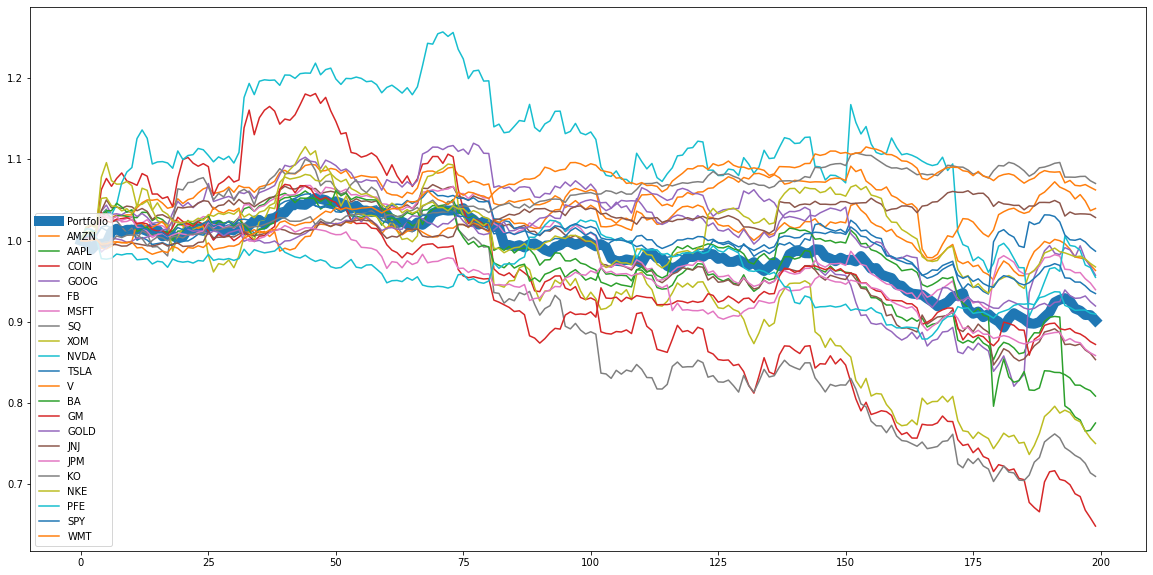

In [15]:
plt.figure(figsize=(20,10))
pd.Series(p_evolution).reset_index(drop=True).plot(linewidth=10)
for a in assets_data_list_test:
    (a.iloc[50:,0]/a.iloc[50,0]).reset_index(drop=True).plot()
plt.legend(['Portfolio']+list(tickers.keys()),loc=3)

## Markowitz Agent

In [16]:
#env2 = PortfolioEnvironmentTest(tickers.keys(),assets_data_list_test,fee=fee,look_back_window=window)
policy_M = MarkowitzAgent()
#action = np.clip(np.random.normal(2,3,size=env.action_space.shape[0]),0,None)
#action = action/action.sum()
state = env2.reset()
done = False
total_reward = 0
infos_M = []
#state, reward, done, info = env2.step(action)
#state["data"].shape
while not done:
    action = policy_M.select_action(state)
    #print(action)
    state, reward, done, info = env2.step(action)
    #print(reward)
    total_reward += reward
    infos_M.append(info)
    #print(action)

print(total_reward)

-5395.240735410989


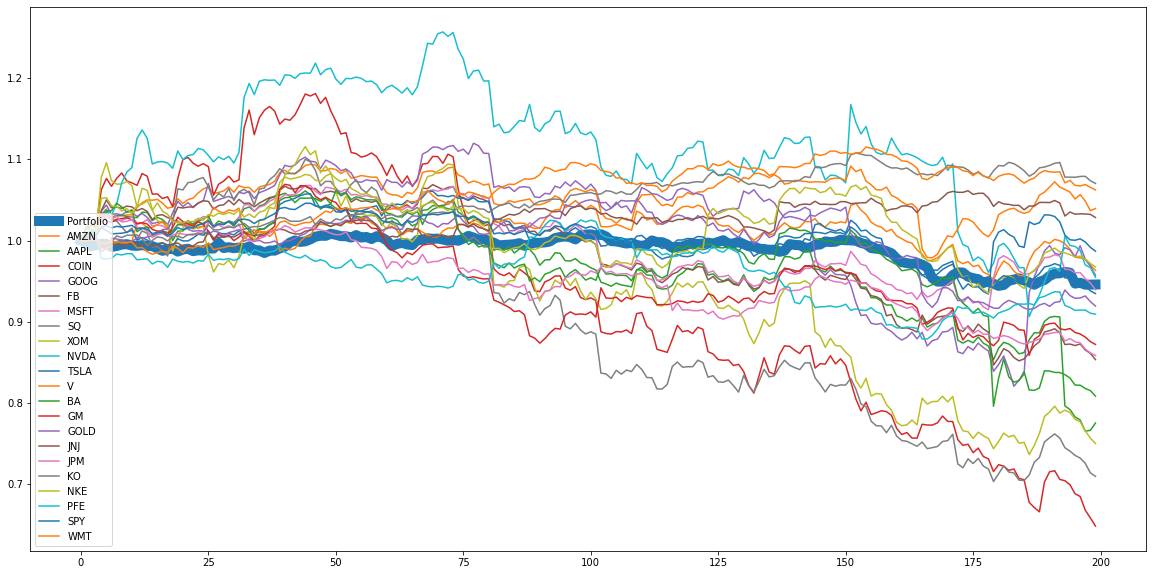

In [18]:
p_evolution_m = [1.0]
for info in infos_M:
    p_evolution_m.append(info['value'])
    
plt.figure(figsize=(20,10))
pd.Series(p_evolution_m).reset_index(drop=True).plot(linewidth=10)
for a in assets_data_list_test:
    (a.iloc[50:,0]/a.iloc[50,0]).reset_index(drop=True).plot()
plt.legend(['Portfolio']+list(tickers.keys()),loc=3)

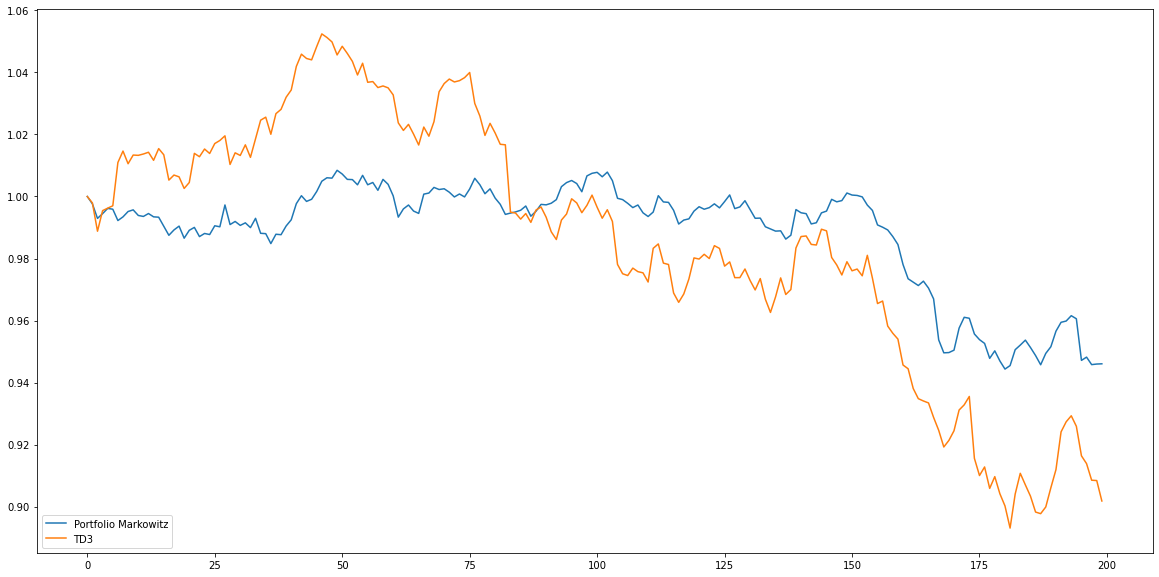

In [19]:
plt.figure(figsize=(20,10))
pd.Series(p_evolution_m).reset_index(drop=True).plot()
pd.Series(p_evolution).reset_index(drop=True).plot()
plt.legend(['Portfolio Markowitz','TD3'],loc=3)

Grafico 1 hora

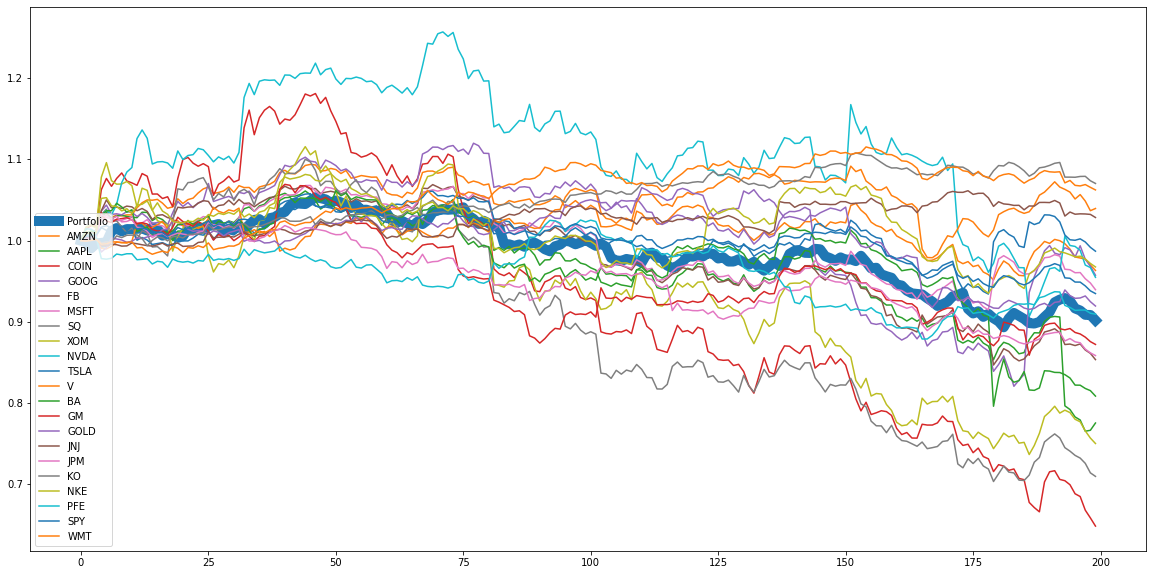

In [20]:
plt.figure(figsize=(20,10))
pd.Series(p_evolution).reset_index(drop=True).plot(linewidth=10)
for a in assets_data_list_test:
    (a.iloc[50:,0]/a.iloc[50,0]).reset_index(drop=True).plot()
plt.legend(['Portfolio']+list(tickers.keys()),loc=3)

In [38]:
target_test = target.tail(max_steps+window).to_numpy().reshape(1,-1)[0]
env2 = PortfolioEnvironmentTargetRewardTest(tickers.keys(),assets_data_list_test,target_test,fee=fee,look_back_window=window)

#for m in os.listdir('./models'):
policy.load(f'./models/22_05_2022_10_34_05')
state = env2.reset()
done = False
total_reward = 0
infos = []

while not done:
    action = policy.select_action(reshape_dict_state(state))
    state, reward, done, info = env2.step(action)
    #print(reward)
    total_reward += reward
    infos.append(info)
    #print(action)

print(total_reward)

-1889.0497916979655


In [39]:
p_evolution = [1.0]
for info in infos:
    p_evolution.append(info['value'])

<AxesSubplot:>

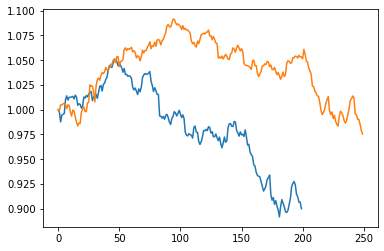

In [40]:
pd.Series(p_evolution).reset_index(drop=True).plot()
pd.Series(target_test/target_test[0]).plot()

# ------ PRUEBAS---------

In [27]:
max_value = 0
index = 0
for i,v in enumerate(info_list):
    if v['value'] > max_value:
        max_value = v['value']
        index = i
print(max_value)
print(info_list[index])


1.1928068269087038
{'weights': array([0.        , 0.12493297, 0.        , 0.12493297, 0.12493297,
       0.        , 0.12493297, 0.12493297, 0.12493297, 0.00053627,
       0.12493297, 0.12493297], dtype=float32), 'value': 1.1928068269087038, 'position': 940}


In [45]:
info_list[index-173] #+26 es el ultimo

{'weights': array([0.1279268 , 0.1328057 , 0.        , 0.07251303, 0.04147185,
        0.        , 0.05293043, 0.08518989, 0.0713501 , 0.00406993,
        0.07308968, 0.33865255], dtype=float32),
 'value': 0.9978198170743418,
 'position': 767}

In [46]:
#pos 249
weights = []
for d in info_list[index-173:index+27]:
    weights.append(d['weights'])
weights = np.array(weights)
weights.shape

(200, 12)

In [51]:
weights[3]

array([2.29485458e-10, 1.21506825e-01, 0.00000000e+00, 1.21506825e-01,
       1.21506825e-01, 0.00000000e+00, 1.21506825e-01, 1.21506825e-01,
       1.21506825e-01, 2.79453751e-02, 1.21506825e-01, 1.21506825e-01],
      dtype=float32)

In [47]:
data = env.buffer.data
data = data[:,50:250,1].T
data = np.concatenate((np.ones(shape=(data.shape[0],1)),data),axis=1)
data

array([[1.00000e+00, 1.27780e+02, 3.20927e+03, ..., 6.45960e+02,
        2.26920e+02, 5.98600e+01],
       [1.00000e+00, 1.27860e+02, 3.21878e+03, ..., 6.45240e+02,
        2.26860e+02, 5.99200e+01],
       [1.00000e+00, 1.27720e+02, 3.22276e+03, ..., 6.38120e+02,
        2.25840e+02, 6.00200e+01],
       ...,
       [1.00000e+00, 1.30440e+02, 3.50097e+03, ..., 6.24820e+02,
        2.30520e+02, 5.89100e+01],
       [1.00000e+00, 1.30270e+02, 3.49281e+03, ..., 6.25000e+02,
        2.30720e+02, 5.86100e+01],
       [1.00000e+00, 1.30400e+02, 3.49101e+03, ..., 6.22430e+02,
        2.30380e+02, 5.86400e+01]])

In [49]:
data.shape

(200, 12)

In [66]:
portfolio_value = []
valor = 100000
for i in range(1,data.shape[0]):
    valor = (weights[i-1]*valor/data[i-1]*data[i]).sum()
    portfolio_value.append(valor)

<AxesSubplot:>

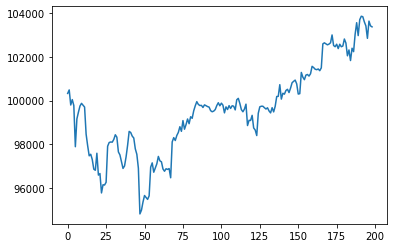

In [73]:
pd.Series(portfolio_value).plot()